<a href="https://colab.research.google.com/github/maxmatical/ml-cheatsheet/blob/master/Pytorch_Lightning_BERT_Huggingface.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inspirations
https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

https://github.com/mgrankin/over9000/blob/master/train.py


https://medium.com/pytorch/getting-started-with-ray-lightning-easy-multi-node-pytorch-lightning-training-e639031aff8b


In [1]:
!nvidia-smi

Wed Dec 29 20:36:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    88W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%%capture
!pip install transformers
!pip install pytorch_lightning
!pip install torchmetrics

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import OneCycleLR # , ReduceLROnPlateau
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
  
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor, StochasticWeightAveraging
from pytorch_lightning.loggers import TensorBoardLogger
import torchmetrics
from torchmetrics.functional import accuracy, f1, auroc

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

In [4]:
# pretrained model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")
model = AutoModel.from_pretrained("distilroberta-base")

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Data

In [5]:
!gdown --id 1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr

Downloading...
From: https://drive.google.com/uc?id=1VuQ-U7TtggShMeuRSA_hzC8qGDl2LRkr
To: /content/toxic_comments.csv
100% 68.8M/68.8M [00:00<00:00, 119MB/s]


In [6]:
df = pd.read_csv("toxic_comments.csv")

df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
train_df, val_df = train_test_split(df, test_size=0.15)

In [8]:
# subsample clean comments
LABEL_COLUMNS = df.columns.tolist()[2:]

train_toxic = train_df[train_df[LABEL_COLUMNS].sum(axis=1) > 0]
train_clean = train_df[train_df[LABEL_COLUMNS].sum(axis=1) == 0]

train_df = pd.concat([
  train_toxic,
  train_clean.sample(15_000)
])

train_df.shape, val_df.shape

((28787, 8), (23936, 8))

In [9]:
# take only a subsample of each train_df and val_df for faster iterations
train_df = train_df.sample(500)
val_df = val_df.sample(500)

train_df.shape, val_df.shape

((500, 8), (500, 8))

## Creating Dataset and Lightning Data Module

In [10]:
# set batch size and max seq_len
bs = 12
seq_len = 256

In [11]:
class ToxicCommentsDataset(Dataset):

  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: AutoTokenizer,
    max_token_len: int = 128

  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    comment_text = data_row.comment_text
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      comment_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',

    )

    return dict(
      # comment_text=comment_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels = torch.IntTensor(labels)
    #   labels=torch.FloatTensor(labels)
    )

In [12]:
# test
train_dataset = ToxicCommentsDataset(
  train_df,
  tokenizer,
  max_token_len=seq_len
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['input_ids', 'attention_mask', 'labels'])

In [14]:
print(sample_item["input_ids"], sample_item["labels"])
print(sample_item["input_ids"].shape)

tensor([    0,  1185, 11216,  1368,  3540,     4,  1437, 50118, 50118, 25266,
         1810,     6, 32594,     4,     2,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1, 

In [15]:
class ToxicCommentsDataModule(pl.LightningDataModule):
  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=512):
    super().__init__()
    self.train_df, self.test_df = train_df, test_df
    self.tokenizer = tokenizer
    self.batch_size = batch_size
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ToxicCommentsDataset(
        self.train_df,
        self.tokenizer,
        self.max_token_len
    )

    self.test_dataset = ToxicCommentsDataset(
        self.test_df,
        self.tokenizer,
        self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
        self.train_dataset,
        batch_size = self.batch_size,
        shuffle = True,
        num_workers=1
    )

  def val_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers=1
    )

  def test_dataloader(self):
    return DataLoader(
        self.test_dataset,
        batch_size = self.batch_size,
        shuffle = False,
        num_workers=1
    )

In [16]:
data_module = ToxicCommentsDataModule(
    train_df,
    val_df,
    tokenizer,
    batch_size = bs,
    max_token_len = seq_len
)


In [17]:
data_module.setup() # call this before getting len of dataloader

In [18]:
len(data_module.train_dataloader())

42

# Model

In [19]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=1)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 256]), torch.Size([8, 256]))

In [20]:
output = model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [21]:
output.pooler_output.shape

torch.Size([8, 768])

In [22]:
# test lr schedule with https://www.kaggle.com/isbhargav/guide-to-pytorch-learning-rate-scheduling
# test wtih flat cos lr

In [23]:
class BertModel(nn.Module):
  def __init__(self, n_classes: int):
    super().__init__()
    self.model = model
    self.classifier = nn.Linear(self.model.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask): 
    out = self.model(input_ids, attention_mask=attention_mask)
    out = self.classifier(out.pooler_output)
    return out

In [24]:
bert_model = BertModel(len(LABEL_COLUMNS))

In [25]:
# bert_model(sample_batch["input_ids"], sample_batch["attention_mask"]).shape  # should be bs x 6

configuring multiple optimizers: https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html?highlight=scheduler#configure-optimizers

In [80]:
class ToxicCommentClassifier(pl.LightningModule):
  def __init__(self, pytorch_model: nn.Module, total_steps: int, lr: float = 2e-5, accumulate_grad_batches: int = 1):
    super().__init__()
    self.lr = lr
    self.total_steps = total_steps # for lr schedule
    self.accumulate_grad_batches = accumulate_grad_batches # used as step freq for lr schedule

    self.pytorch_model = pytorch_model
    self.criterion = nn.BCEWithLogitsLoss() # bce for multi-label
    # self.criterion = nn.BCELoss()

    # metrics 
    self.f1 = torchmetrics.F1()

    # use automatic optimization to true
    self.automatic_optimization = True

    self.lrs = []

  def forward(self, input_ids, attention_mask):
    """
    forward step for lightning module
    """
    out = self.pytorch_model(input_ids, attention_mask=attention_mask)
    return out

  def training_step(self, batch, batch_idx):
    """
    using automatic optimization: no need to define opt steps etc.
    """
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    out = self(input_ids, attention_mask)
       
    # compute loss + metrics
    loss = self.criterion(out, labels.to(dtype=torch.float32)) # cast to float because labels is in Int
    f1 = self.f1(out, labels)

    # log loss and metrics each k steps and each epoch
    log_values = {"loss": loss, "train_f1": f1}
    self.log_dict(log_values, sync_dist=True, prog_bar=True, on_step=True, on_epoch=True)

    # track lr just to see if things are working correctly
    curr_lr = self.scheduler.get_last_lr()
    self.lrs.append(curr_lr[0])


    return {"loss": loss, "train_f1": f1}

  def validation_step(self, batch, batch_idx):
    """
    validation step
    get validation loss and accuracy metrics
    """
    # batch comes from dataset
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]

    out = self(input_ids, attention_mask)

    # compute loss + metrics
    loss = self.criterion(out, labels.to(dtype=torch.float32)) # cast to float because labels is in Int
    f1 = self.f1(out, labels)
    # log loss and metrics each k steps and each epoch
    log_values = {"val_loss": loss, "val_f1": f1}
    self.log_dict(log_values, sync_dist=True, prog_bar=True, on_step=True, on_epoch=True)
    return {"val_loss": loss, "val_f1": f1}

  def training_epoch_end(self, outputs):
    """
    after every training epoch, log train metrics

    note: this might not be needed if logging is done for each step and epoch
    """
    # log validation loss and metrics
    avg_loss = torch.stack([x["loss"] for x in outputs]).mean()
    avg_f1 = torch.stack([x["train_f1"] for x in outputs]).mean()

    self.log("avg_train_loss", avg_loss, sync_dist=True, prog_bar=True)
    self.log("avg_train_f1", avg_f1, sync_dist=True, prog_bar=True)

  def validation_epoch_end(self, outputs):
    """
    after every training epoch, log val metrics

    note: this might not be needed if logging is done for each step and epoch
    """
    # log validation loss and metrics
    avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    avg_f1 = torch.stack([x["val_f1"] for x in outputs]).mean()
    self.log("avg_val_loss", avg_loss, sync_dist=True, prog_bar=True)
    self.log("avg_val_f1", avg_f1, sync_dist=True, prog_bar=True)

  def configure_optimizers(self):
    # TODO: 
    # 1. add flat cos
    # 2. make lr scheduler configurable(one_cycle vs flat_cos)
    # 3. potentially add reduce lr on plateau as well

    optimizer = AdamW(self.parameters(), lr=self.lr)

    self.scheduler = OneCycleLR(
      optimizer,
      max_lr=self.lr,
      pct_start=0.3,
      total_steps=self.total_steps
    )
    scheduler_dic = {
        'scheduler': self.scheduler,
        'interval': 'step',
        "frequency": self.accumulate_grad_batches
    }
    return [optimizer], [scheduler_dic]

In [81]:
# training epoch related hyperparams
steps_per_epoch = len(data_module.train_dataloader())
n_epochs = 2
accumulate_grad_batches = 4

total_steps = steps_per_epoch * n_epochs // accumulate_grad_batches
print(f"total_steps: {total_steps}")

total_steps: 21


Note: if using multiple gpus, total steps calculation is something like
```
steps_per_epoch = len(data_module.train_dataloader())

# for gpu or tpu cores
num_devices = 4
if tpu_cores:
    num_devices = max(num_devices, tpu_cores)

accumulate_grad_batches = 1 # for no gradient accumulation

effective_accum = accumulate_grad_batches * num_devices
total_steps (steps_per_epoch // effective_accum) * n_epochs

```

In [82]:
toxic_comment_model = ToxicCommentClassifier(bert_model, lr=2e-5, total_steps=total_steps, accumulate_grad_batches=accumulate_grad_batches)

In [83]:
# toxic_comment_model(sample_batch["input_ids"], sample_batch["attention_mask"])[1].shape  # should be bs x 6

# Trainer

defining the trainer and running `trainer.fit` 

In [84]:
# callbacks
lr_monitor_cb = LearningRateMonitor(logging_interval='step')

checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="avg_val_f1",
  mode="max"
)

early_stopping_callback = EarlyStopping(monitor='val_loss', patience=6)

# swa = StochasticWeightAveraging(swa_epoch_start=0.8, swa_lrs=None)

logger = TensorBoardLogger("lightning_logs", name="toxic-comments")

In [85]:
# standard callback, checkpoint and early stopping
callbacks = [lr_monitor_cb, checkpoint_callback, early_stopping_callback]

In [86]:
trainer = pl.Trainer(
    logger=logger,
    callbacks = callbacks,
    precision=32,
    max_epochs = n_epochs,
    accelerator="gpu",
    devices=1,
    accumulate_grad_batches = accumulate_grad_batches
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [87]:
# optional: lr finder
# lr_finder = trainer.tuner.lr_find(model=toxic_comment_model, datamodule=data_module)

In [88]:
trainer.fit(toxic_comment_model, data_module)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  f"DataModule.{name} has already been called, so it will not be called again. "
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type              | Params
----------------------------------------------------
0 | pytorch_model | BertModel         | 82.1 M
1 | criterion     | BCEWithLogitsLoss | 0     
2 | f1            | F1                | 0     
----------------------------------------------------
82.1 M    Trainable params
0         Non-trainable params
82.1 M    Total params
328.492   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /content/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint

Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:413: UserWarning: The number of training samples (42) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 10: avg_val_f1 reached 0.50271 (best 0.50271), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 21: avg_val_f1 reached 0.53552 (best 0.53552), saving model to "/content/checkpoints/best-checkpoint-v3.ckpt" as top 1
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/core/datamodule.py:470: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  f"DataModule.{name} has already been called, so it will not be called again. "


In [89]:
# check lr scheduler working as intended
len(toxic_comment_model.lrs), max(toxic_comment_model.lrs)

(84, 1.9888308709018238e-05)

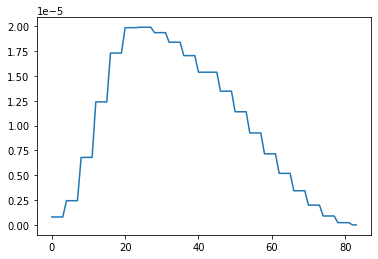

In [91]:
from matplotlib import pyplot as plt

plt.plot(toxic_comment_model.lrs)

In [92]:
trainer.logged_metrics

{'avg_train_accuracy': 0.7865777611732483,
 'avg_train_loss': 0.042027246206998825,
 'avg_val_f1': 0.5355244874954224,
 'avg_val_loss': 0.09359695762395859,
 'loss_epoch': 0.16770172119140625,
 'loss_step': tensor(0.2190),
 'train_f1_epoch': 0.7867752909660339,
 'train_f1_step': tensor(0.7619),
 'val_f1_epoch': 0.5398086309432983,
 'val_f1_step': 0.0,
 'val_loss_epoch': 0.09398338943719864,
 'val_loss_step': 0.04529694840312004}

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir lightning_logs/


# Saving only the pytorch model

In [ ]:
# saving model weights
saved_model_pth = "saved_model.pth"

torch.save(toxic_comment_model.pytorch_model.state_dict(), saved_model_pth)

# Exporting model as pure pytorch 

In [ ]:
new_bert_model = BertModel(6)

new_bert_model.load_state_dict(torch.load(saved_model_pth))

In [ ]:
# check values are the same

inf_preds = new_bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])
print(inf_preds.shape) # should be 8 x 6
inf_preds

In [ ]:
toxic_comment_model(sample_batch["input_ids"], sample_batch["attention_mask"])[1]